## 1.Environment Setup & Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define path
data_path = '/home/sysadmin/ResearchProject-Experiments/datasets/student_grade.csv'



In [ ]:
df = pd.read_csv(data_path, low_memory=False)
df

## 2.Data Loading & Preprocessing

In [2]:
# Check if file exists
if not os.path.exists(data_path):
    print(f"Error: The file '{data_path}' was not found.")
else:
    print("File found. Loading data...")

    # === 2.1 Load Data ===
    df = pd.read_csv(data_path, low_memory=False)

    # === 2.2 Transform Data (Wide to Long) ===
    id_vars = ['student_id']
    df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

    # === 2.3 Clean Data ===
    # Convert grade to numeric and remove invalid/empty grades
    df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
    df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

    # === 2.4 Filter for 'INT' Courses Only ===
    # This ensures the model only learns from INT courses
    df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

    print(f"--- Data Preparation Complete ---")
    print(f"Total records after cleaning: {len(df_long_cleaned)}")
    print(f"Filtered to INT courses only: {len(df_long_filtered)}")
    display(df_long_filtered)
    
    # === 2.5 Advanced Data Filtering ===
MIN_GRADES_PER_STUDENT = 5   # นักเรียนต้องมีเกรดอย่างน้อย 5 วิชา (ถ้าน้อยกว่านี้ Model จะเดานิสัยยาก)
MIN_STUDENTS_PER_COURSE = 10 # วิชานั้นต้องมีคนเรียนอย่างน้อย 10 คน (ถ้าน้อยกว่านี้ Model จะไม่รู้นิสัยวิชา)

print(f"\n--- Starting Advanced Filtering ---")
print(f"Original Count: {len(df_long_filtered)}")

# 1. กรองนักเรียนที่มีข้อมูลน้อยออก
student_counts = df_long_filtered['student_id'].value_counts()
valid_students = student_counts[student_counts >= MIN_GRADES_PER_STUDENT].index
df_step1 = df_long_filtered[df_long_filtered['student_id'].isin(valid_students)]
print(f"After removing students with < {MIN_GRADES_PER_STUDENT} grades: {len(df_step1)}")

# 2. กรองวิชาที่มีข้อมูลน้อยออก
course_counts = df_step1['course'].value_counts()
valid_courses = course_counts[course_counts >= MIN_STUDENTS_PER_COURSE].index
df_final = df_step1[df_step1['course'].isin(valid_courses)].copy()
print(f"After removing courses with < {MIN_STUDENTS_PER_COURSE} students: {len(df_final)}")

# === 2.6 Summary ===
print(f"\n--- Final Data for Modeling ---")
print(f"Total records: {len(df_final)}")
print(f"Unique Students: {df_final['student_id'].nunique()}")
print(f"Unique Courses: {df_final['course'].nunique()}")



File found. Loading data...
--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
25871,A246,INT102 WEB TECHNOLOGY,1.5
27143,A632,INT102 WEB TECHNOLOGY,3.0
27144,A086,INT102 WEB TECHNOLOGY,4.0
27145,A662,INT102 WEB TECHNOLOGY,4.0
27146,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
592988,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
592990,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593003,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593005,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5



--- Starting Advanced Filtering ---
Original Count: 17468
After removing students with < 5 grades: 17412
After removing courses with < 10 students: 17380

--- Final Data for Modeling ---
Total records: 17380
Unique Students: 647
Unique Courses: 48


## 3.Load Data and adjust rating scale

In [3]:
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_final[['student_id', 'course', 'grade']], reader)

## 4.Parameter Tuning

In [4]:
param_grid = {
    'n_factors': [90, 110, 120, 130],
    'n_epochs':  [70, 90, 110],
    # 'n_factors': [50, 70, 90, 110],
    # 'n_epochs': [80, 90, 100],
    'reg_pu':    [0.04, 0.06, 0.08], # Regularization สำหรับ user latent factors
    'reg_qi':    [0.04, 0.06, 0.08] # Regularization สำหรับ item latent factors
}

gs = GridSearchCV(
    NMF,
    param_grid,
    measures=['rmse', 'mae'],
    cv=5,    # fold cross-validation
    joblib_verbose=3
)

print("🚀 Start GridSearchCV (NMF)...")
gs.fit(data)
print("✅ GridSearchCV Finished")

🚀 Start GridSearchCV (NMF)...


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   15.0s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done 511 tasks      | elapsed:  6.3min


✅ GridSearchCV Finished


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  6.8min finished


In [5]:
print("Best RMSE score:", gs.best_score['rmse'])
print("Best params for RMSE:")
print(gs.best_params['rmse'])

print("\nBest MAE score:", gs.best_score['mae'])
print("Best params for MAE:")
print(gs.best_params['mae'])

Best RMSE score: 0.5534081388145998
Best params for RMSE:
{'n_factors': 130, 'n_epochs': 110, 'reg_pu': 0.04, 'reg_qi': 0.04}

Best MAE score: 0.4344133885509328
Best params for MAE:
{'n_factors': 130, 'n_epochs': 90, 'reg_pu': 0.06, 'reg_qi': 0.04}


### RMSE DataFram

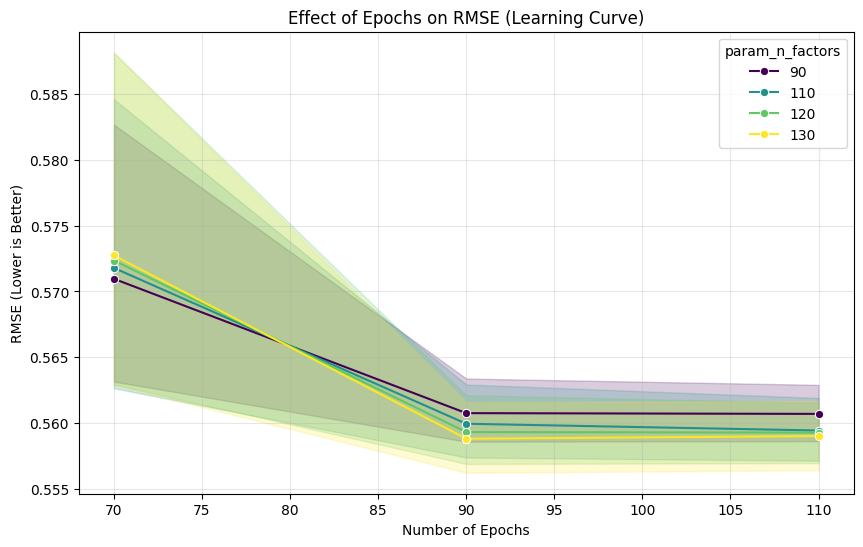

In [6]:
# 1. แปลงผลลัพธ์ทั้งหมดจาก Grid Search มาเป็น DataFrame เพื่อให้พลอตกราฟง่าย
results_df = pd.DataFrame.from_dict(gs.cv_results)

# -------------------------------------------------------
# Graph 1: Effect of Epochs (Learning Curve)
# ดูว่า "จำนวนรอบการเรียนรู้" ส่งผลต่อ Error อย่างไร
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# แกน X: จำนวน Epochs
# แกน Y: ค่า Error (RMSE)
# Hue (สีเส้น): แยกตามจำนวน Factors (ความซับซ้อนของโมเดล)
sns.lineplot(data=results_df, x='param_n_epochs', y='mean_test_rmse',
             hue='param_n_factors', marker='o', palette='viridis')

plt.title('Effect of Epochs on RMSE (Learning Curve)')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE (Lower is Better)')
plt.grid(True, alpha=0.3)
plt.show()

### RMSE Heatmap

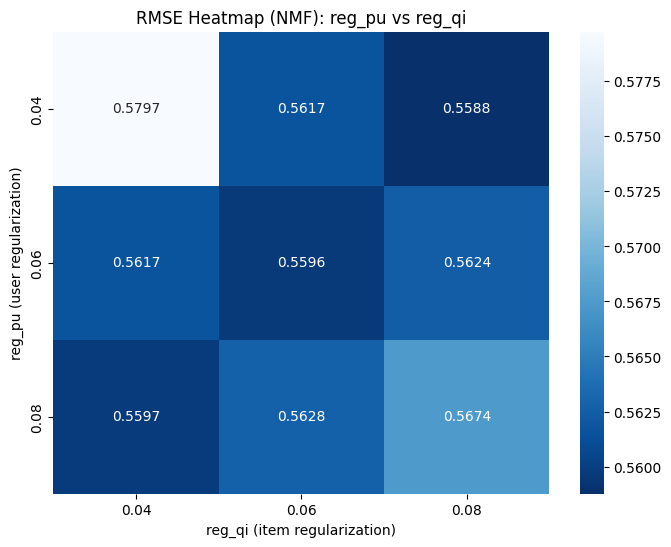

In [7]:
# -------------------------------------------------------
# Graph 2: Heatmap (reg_pu vs reg_qi)
# ดูจุดที่ RMSE ต่ำที่สุดจากค่าคู่ของ regularization
# -------------------------------------------------------
pivot_table = results_df.pivot_table(
    values='mean_test_rmse',
    index='param_reg_pu',    # แกนตั้ง: reg_pu
    columns='param_reg_qi'   # แกนนอน: reg_qi
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='.4f',
    cmap='Blues_r'  # ยิ่งเข้ม = RMSE ยิ่งต่ำ (ดีกว่า)
)

plt.title('RMSE Heatmap (NMF): reg_pu vs reg_qi')
plt.xlabel('reg_qi (item regularization)')
plt.ylabel('reg_pu (user regularization)')
plt.show()